In [1]:
import warnings
warnings.filterwarnings('ignore')

import koreanize_matplotlib

## 앙상블 단계별 비교

In [2]:
import pandas as pd
# ======================
# 0) 경로 & 상수
# ======================
TRAIN_PATH = "Data/train_0822_changed.csv"
TEST_PATH  = "Data/test_0822_changed.csv"
SUB_PATH   = "Data/sample_submission.csv"

KEYS   = ["num_date_time", "건물번호"]
TARGET = "전력소비량(kWh)"
BASE_DROP_COMMON = ["num_date_time", "일시"]  # 공통 시간 문자열
BASE_DROP_TRAIN  = ["건물유형", TARGET]       # 모델1·3 (건물유형 split)에서 drop
BASE_DROP_TEST   = ["건물유형"]

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sub   = pd.read_csv(SUB_PATH)


In [3]:
train['train_group4'].value_counts()

train_group4
호텔          20400
상용          20400
학교          20400
건물기타        20400
병원          18360
아파트         18360
연구소         18360
IDC(전화국)    18360
공공          16320
백화점10       12240
백화점         10200
백화점11       10200
Name: count, dtype: int64

In [4]:
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom = np.where(denom == 0, 1, denom)
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100

def coerce_numeric_objects(df: pd.DataFrame) -> pd.DataFrame:
    """object/category 컬럼을 안전하게 숫자로 변환 (숫자/기호 혼재 대응)"""
    out = df.copy()
    for c in out.columns:
        if str(out[c].dtype) in ["object", "category"]:
            out[c] = pd.to_numeric(
                out[c].astype(str).str.replace(r"[^\d\.\-eE]", "", regex=True),
                errors="coerce"
            )
    return out

def reorder_like(X_to_fix, X_ref):
    """X_to_fix를 X_ref의 컬럼 순서/구성에 맞춘다. 누락은 NaN으로 채움."""
    return X_to_fix.reindex(columns=X_ref.columns, fill_value=np.nan)

In [6]:
# ======================
# 모델 2 — XGBoost (train_group별) + Optuna 튜닝 (SMAPE 최소)
# ======================
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import optuna

# ---------- 유틸 ----------
def smape(y_true, y_pred):
    return 100 * np.mean(2*np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

def to_numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for c in out.columns:
        if str(out[c].dtype) in ["object", "category"]:
            out[c] = pd.to_numeric(
                out[c].astype(str).str.replace(r"[^\d\.\-eE]", "", regex=True),
                errors="coerce"
            )
    return out

# ---------- 공통 세팅 ----------
RANDOM_STATE = 42
VAL_SIZE = 0.2
EARLY_STOP = 100
N_TRIALS = 40          # 필요시 늘리면 됨
USE_GPU = False        # GPU면 True로 바꾸기
GROUP_COL = 'train_group4'

# 결과 수집 컨테이너
val_oofs_2, test_preds_2 = [], []
val_scores_2 = {}
best_params_by_group = {}

# ---------- 그룹 루프 ----------
groups = train[GROUP_COL].dropna().unique()

for gkey in groups:
    tr_sub = train[train[GROUP_COL] == gkey].copy()
    te_sub = test [test [GROUP_COL] == gkey].copy()
    if len(tr_sub) == 0:
        continue

    # 1) Feature/Target 만들기
    drop_cols_tr = BASE_DROP_COMMON + ["cluster_id", "건물번호", TARGET] + [GROUP_COL]
    X_all = tr_sub.drop(columns=[c for c in drop_cols_tr if c in tr_sub.columns], errors="ignore")
    y_all = tr_sub[TARGET].astype(float)

    # 숫자화 + 결측
    X_all = to_numeric_df(X_all).fillna(0.0)

    # 2) 고정 분할
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_all, y_all, test_size=VAL_SIZE, random_state=38
    )

    # ---------- Optuna 목적 함수 ----------
    def objective(trial: optuna.Trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 400, 1600),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "max_depth": trial.suggest_int("max_depth", 5, 12),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
            "random_state": RANDOM_STATE,
            "n_jobs": -1,
            "tree_method": "gpu_hist" if USE_GPU else "hist",
            "eval_metric": "mae",  # early stopping용. 최종 평가는 SMAPE로.
        }

        model = xgb.XGBRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        # best_iteration 고려
        best_iter = getattr(model, "best_iteration", None)
        pred_val = model.predict(
            X_val,
            iteration_range=(0, best_iter + 1) if best_iter is not None else None
        )
        score = smape(y_val.values, pred_val)
        # pruning(선택): 중간값 보고 가능하지만 여기선 단순 반환
        return score

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)

    best_params = study.best_trial.params
    # 재학습 시, 약간 더 많은 n_estimators로 확보(선택)
    best_params["n_estimators"] = int(best_params["n_estimators"] * 1.1)
    best_params.update({
        "random_state": RANDOM_STATE,
        "n_jobs": -1,
        "tree_method": "gpu_hist" if USE_GPU else "hist",
        "eval_metric": "mae",
    })
    best_params_by_group[gkey] = best_params

    # ---------- 최종 모델 학습 ----------
    m2 = xgb.XGBRegressor(**best_params)
    m2.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    best_iter = getattr(m2, "best_iteration", None)

    # 검증 예측 + 점수 저장
    val_pred = m2.predict(
        X_val, iteration_range=(0, best_iter + 1) if best_iter is not None else None
    )
    score = smape(y_val.values, val_pred)
    val_scores_2[gkey] = float(score)
    print(f"[{gkey}] best SMAPE={score:.4f} | best_iter={best_iter} | best_params={study.best_trial.params}")

    # OOF 저장
    val_keys = tr_sub.loc[X_val.index, KEYS].reset_index(drop=True)
    oof_df = val_keys.copy()
    oof_df["y_true"] = y_val.reset_index(drop=True).values
    oof_df["pred_2"] = val_pred
    val_oofs_2.append(oof_df)

    # TEST 예측
    X_test = te_sub.drop(columns=[c for c in BASE_DROP_COMMON + ["cluster_id", GROUP_COL] if c in te_sub.columns], errors="ignore")
    X_test = to_numeric_df(X_test).fillna(0.0)
    X_test = X_test.reindex(columns=X_tr.columns, fill_value=0.0)
    te_pred = m2.predict(
        X_test, iteration_range=(0, best_iter + 1) if best_iter is not None else None
    )
    test_preds_2.append(te_sub[KEYS].assign(pred_2=te_pred))

# --- 그룹별 최적 파라미터 확인용 ---
# print(best_params_by_group)


[I 2025-08-23 09:59:19,335] A new study created in memory with name: no-name-a313f640-c3ea-40db-bffe-3ec21ee398f7
[I 2025-08-23 09:59:22,214] Trial 0 finished with value: 6.560507725192606 and parameters: {'n_estimators': 1346, 'learning_rate': 0.07715961970996692, 'max_depth': 6, 'min_child_weight': 9.03954403115979, 'subsample': 0.9389416069180999, 'colsample_bytree': 0.7313399983712895, 'gamma': 4.109281814343375, 'reg_alpha': 1.7178340511458128, 'reg_lambda': 7.288352503452171}. Best is trial 0 with value: 6.560507725192606.
[I 2025-08-23 09:59:28,750] Trial 1 finished with value: 5.758544516909529 and parameters: {'n_estimators': 1547, 'learning_rate': 0.06678017478159541, 'max_depth': 8, 'min_child_weight': 1.7619786406220097, 'subsample': 0.9123164577392513, 'colsample_bytree': 0.9147886030483457, 'gamma': 0.9516566859516784, 'reg_alpha': 1.7898372296013576, 'reg_lambda': 8.086533968114423}. Best is trial 1 with value: 5.758544516909529.
[I 2025-08-23 09:59:31,335] Trial 2 finis

[호텔] best SMAPE=4.9770 | best_iter=None | best_params={'n_estimators': 1329, 'learning_rate': 0.014350325475766215, 'max_depth': 12, 'min_child_weight': 5.221870916020334, 'subsample': 0.9913539328879973, 'colsample_bytree': 0.6893759949785345, 'gamma': 2.9528029545321077, 'reg_alpha': 2.804220188375324, 'reg_lambda': 0.031063347454793916}


[I 2025-08-23 10:03:42,580] Trial 0 finished with value: 2.72197273150491 and parameters: {'n_estimators': 1135, 'learning_rate': 0.1253052759785928, 'max_depth': 10, 'min_child_weight': 3.9779223030064172, 'subsample': 0.7538699128838744, 'colsample_bytree': 0.7789464717834323, 'gamma': 4.053701466852951, 'reg_alpha': 0.6088136017404416, 'reg_lambda': 8.982193663881318}. Best is trial 0 with value: 2.72197273150491.
[I 2025-08-23 10:03:46,865] Trial 1 finished with value: 2.9687141544890236 and parameters: {'n_estimators': 1528, 'learning_rate': 0.08913682491008731, 'max_depth': 7, 'min_child_weight': 9.270629865682027, 'subsample': 0.844072444754641, 'colsample_bytree': 0.8831014150921953, 'gamma': 4.090996929770578, 'reg_alpha': 1.7928568802439742, 'reg_lambda': 4.196411550890733}. Best is trial 0 with value: 2.72197273150491.
[I 2025-08-23 10:03:53,401] Trial 2 finished with value: 2.78640854411632 and parameters: {'n_estimators': 1116, 'learning_rate': 0.11701437731628418, 'max_de

[상용] best SMAPE=2.3915 | best_iter=None | best_params={'n_estimators': 1195, 'learning_rate': 0.08515845683449294, 'max_depth': 12, 'min_child_weight': 3.0327210287347905, 'subsample': 0.9108495770581955, 'colsample_bytree': 0.8339473545977342, 'gamma': 0.20734893264569954, 'reg_alpha': 4.631782424299705, 'reg_lambda': 1.8875743401425815}


[I 2025-08-23 10:07:44,857] Trial 0 finished with value: 2.693452625624038 and parameters: {'n_estimators': 835, 'learning_rate': 0.04099986837045145, 'max_depth': 12, 'min_child_weight': 5.222364134318684, 'subsample': 0.7095568294028259, 'colsample_bytree': 0.7327286341816431, 'gamma': 0.7820151752647053, 'reg_alpha': 4.689671821141222, 'reg_lambda': 9.20810247634015}. Best is trial 0 with value: 2.693452625624038.
[I 2025-08-23 10:07:49,503] Trial 1 finished with value: 2.8407708832534495 and parameters: {'n_estimators': 1490, 'learning_rate': 0.02609481590778893, 'max_depth': 8, 'min_child_weight': 9.267651911482666, 'subsample': 0.6661356038367007, 'colsample_bytree': 0.7636377757218706, 'gamma': 3.307885041243784, 'reg_alpha': 3.2260101550864166, 'reg_lambda': 3.888204149018483}. Best is trial 0 with value: 2.693452625624038.
[I 2025-08-23 10:07:52,547] Trial 2 finished with value: 2.7650749406028243 and parameters: {'n_estimators': 485, 'learning_rate': 0.04537531734877855, 'max

[병원] best SMAPE=2.6164 | best_iter=None | best_params={'n_estimators': 1272, 'learning_rate': 0.020078243914778676, 'max_depth': 12, 'min_child_weight': 1.5066390087444685, 'subsample': 0.7125983604414623, 'colsample_bytree': 0.9626575563348168, 'gamma': 1.0114001820286818, 'reg_alpha': 1.5588446549889405, 'reg_lambda': 0.9721890537233397}


[I 2025-08-23 10:12:05,231] Trial 0 finished with value: 3.2106985762057616 and parameters: {'n_estimators': 425, 'learning_rate': 0.11140581731251746, 'max_depth': 9, 'min_child_weight': 8.844753805117058, 'subsample': 0.9849341663961428, 'colsample_bytree': 0.990020860010767, 'gamma': 1.5854131570545738, 'reg_alpha': 4.018559286543826, 'reg_lambda': 1.5801761332322994}. Best is trial 0 with value: 3.2106985762057616.
[I 2025-08-23 10:12:08,559] Trial 1 finished with value: 3.2523912808539905 and parameters: {'n_estimators': 449, 'learning_rate': 0.14076491068327696, 'max_depth': 11, 'min_child_weight': 5.787153508486506, 'subsample': 0.6483019129511813, 'colsample_bytree': 0.9474006054556076, 'gamma': 2.293549058226324, 'reg_alpha': 2.5693821086689845, 'reg_lambda': 8.46455371854661}. Best is trial 0 with value: 3.2106985762057616.
[I 2025-08-23 10:12:16,414] Trial 2 finished with value: 2.9144574112735393 and parameters: {'n_estimators': 1120, 'learning_rate': 0.020130024644008194, 

[학교] best SMAPE=2.7665 | best_iter=None | best_params={'n_estimators': 1236, 'learning_rate': 0.03128543738371176, 'max_depth': 10, 'min_child_weight': 2.531144077870502, 'subsample': 0.7118162568610588, 'colsample_bytree': 0.7455557509441209, 'gamma': 0.5242742216469632, 'reg_alpha': 2.066973067850731, 'reg_lambda': 3.634987784504208}


[I 2025-08-23 10:17:13,608] Trial 0 finished with value: 5.0132208191875565 and parameters: {'n_estimators': 1052, 'learning_rate': 0.0132125564955989, 'max_depth': 9, 'min_child_weight': 2.091849744127976, 'subsample': 0.7180394731070655, 'colsample_bytree': 0.6154695142508384, 'gamma': 1.8316601521299591, 'reg_alpha': 3.7334561664345056, 'reg_lambda': 1.629279516328318}. Best is trial 0 with value: 5.0132208191875565.
[I 2025-08-23 10:17:16,129] Trial 1 finished with value: 6.323736841510559 and parameters: {'n_estimators': 767, 'learning_rate': 0.015570690346678582, 'max_depth': 7, 'min_child_weight': 3.640134896366551, 'subsample': 0.9879146828220059, 'colsample_bytree': 0.9841250209559096, 'gamma': 2.2749585102349226, 'reg_alpha': 4.535091062147833, 'reg_lambda': 0.9311395705958025}. Best is trial 0 with value: 5.0132208191875565.
[I 2025-08-23 10:17:17,518] Trial 2 finished with value: 6.479132965030956 and parameters: {'n_estimators': 462, 'learning_rate': 0.028225395208389844, 

[건물기타] best SMAPE=4.4724 | best_iter=None | best_params={'n_estimators': 1486, 'learning_rate': 0.017825770643168082, 'max_depth': 12, 'min_child_weight': 4.5611201901331055, 'subsample': 0.9277514828849545, 'colsample_bytree': 0.6466168275638721, 'gamma': 0.36446102226489235, 'reg_alpha': 0.8124889455479005, 'reg_lambda': 3.3427685312661937}


[I 2025-08-23 10:22:56,138] Trial 0 finished with value: 13.429087065283362 and parameters: {'n_estimators': 1101, 'learning_rate': 0.13888142939632372, 'max_depth': 6, 'min_child_weight': 8.399926511750596, 'subsample': 0.9199480106863502, 'colsample_bytree': 0.7757589469909343, 'gamma': 4.538407016517153, 'reg_alpha': 1.1179630381644712, 'reg_lambda': 9.532374417088306}. Best is trial 0 with value: 13.429087065283362.
[I 2025-08-23 10:22:58,486] Trial 1 finished with value: 12.604623411190504 and parameters: {'n_estimators': 765, 'learning_rate': 0.1362986251577933, 'max_depth': 7, 'min_child_weight': 4.241440287163616, 'subsample': 0.6397569222568563, 'colsample_bytree': 0.8095526121329852, 'gamma': 4.558064239460133, 'reg_alpha': 0.2824524366373554, 'reg_lambda': 6.008814181042396}. Best is trial 1 with value: 12.604623411190504.
[I 2025-08-23 10:22:59,772] Trial 2 finished with value: 9.780398584049415 and parameters: {'n_estimators': 457, 'learning_rate': 0.034064419932325084, 'm

[아파트] best SMAPE=4.0738 | best_iter=None | best_params={'n_estimators': 1249, 'learning_rate': 0.01609058195854887, 'max_depth': 12, 'min_child_weight': 2.988234964016964, 'subsample': 0.7400457638689517, 'colsample_bytree': 0.9567276629925695, 'gamma': 2.092217625449078, 'reg_alpha': 4.916620155585577, 'reg_lambda': 0.09783816353657723}


[I 2025-08-23 10:29:12,933] Trial 0 finished with value: 4.322325902833967 and parameters: {'n_estimators': 1319, 'learning_rate': 0.03401964865746695, 'max_depth': 8, 'min_child_weight': 1.987178686669555, 'subsample': 0.6718540820243762, 'colsample_bytree': 0.6790180565809446, 'gamma': 0.3475437771945433, 'reg_alpha': 1.44038544777495, 'reg_lambda': 3.4133388532125055}. Best is trial 0 with value: 4.322325902833967.
[I 2025-08-23 10:29:20,077] Trial 1 finished with value: 3.919915998149606 and parameters: {'n_estimators': 983, 'learning_rate': 0.03066532464145454, 'max_depth': 10, 'min_child_weight': 2.0509755441617434, 'subsample': 0.9326693259960953, 'colsample_bytree': 0.9933225961057356, 'gamma': 3.5725432075790837, 'reg_alpha': 4.980047945720669, 'reg_lambda': 2.6662786031373873}. Best is trial 1 with value: 3.919915998149606.
[I 2025-08-23 10:29:23,347] Trial 2 finished with value: 4.759289313769584 and parameters: {'n_estimators': 1182, 'learning_rate': 0.05114528046360808, 'm

[연구소] best SMAPE=3.8120 | best_iter=None | best_params={'n_estimators': 458, 'learning_rate': 0.027090351407406506, 'max_depth': 12, 'min_child_weight': 2.6017808399968945, 'subsample': 0.9197348220841639, 'colsample_bytree': 0.6795662983440148, 'gamma': 0.08717953518276933, 'reg_alpha': 2.0769412672224843, 'reg_lambda': 3.2757272586047668}


[I 2025-08-23 10:32:16,187] Trial 0 finished with value: 4.408569834926188 and parameters: {'n_estimators': 817, 'learning_rate': 0.17868954965695766, 'max_depth': 11, 'min_child_weight': 2.5388877094540128, 'subsample': 0.8108893258475842, 'colsample_bytree': 0.9945027178870824, 'gamma': 4.89784306372859, 'reg_alpha': 2.883525625618306, 'reg_lambda': 7.245869506633724}. Best is trial 0 with value: 4.408569834926188.
[I 2025-08-23 10:32:19,161] Trial 1 finished with value: 4.598316316576275 and parameters: {'n_estimators': 529, 'learning_rate': 0.017266354136425507, 'max_depth': 12, 'min_child_weight': 8.371293603699408, 'subsample': 0.6134299242780303, 'colsample_bytree': 0.6695576546801072, 'gamma': 2.258985040426368, 'reg_alpha': 0.7828435363737724, 'reg_lambda': 9.706732654038861}. Best is trial 0 with value: 4.408569834926188.
[I 2025-08-23 10:32:22,003] Trial 2 finished with value: 4.7675111192624575 and parameters: {'n_estimators': 1373, 'learning_rate': 0.04519597697565977, 'ma

[백화점10] best SMAPE=3.9971 | best_iter=None | best_params={'n_estimators': 1320, 'learning_rate': 0.03550320300935903, 'max_depth': 11, 'min_child_weight': 4.267952979130969, 'subsample': 0.9544141723579636, 'colsample_bytree': 0.7695111366534308, 'gamma': 0.8193933407854537, 'reg_alpha': 0.07730751928279418, 'reg_lambda': 2.7297635767139137}


[I 2025-08-23 10:36:25,262] Trial 0 finished with value: 5.756132899276964 and parameters: {'n_estimators': 1288, 'learning_rate': 0.020779659991646434, 'max_depth': 6, 'min_child_weight': 9.540482978939352, 'subsample': 0.9858801848485713, 'colsample_bytree': 0.9993619532495434, 'gamma': 2.973343162591111, 'reg_alpha': 3.612128422937488, 'reg_lambda': 5.683165446853136}. Best is trial 0 with value: 5.756132899276964.
[I 2025-08-23 10:36:29,107] Trial 1 finished with value: 4.929225199376584 and parameters: {'n_estimators': 1379, 'learning_rate': 0.16113867160738493, 'max_depth': 11, 'min_child_weight': 8.472007826163289, 'subsample': 0.9104644435763813, 'colsample_bytree': 0.9637811859736534, 'gamma': 1.4832889450021551, 'reg_alpha': 2.3664083599152836, 'reg_lambda': 8.985523129811822}. Best is trial 1 with value: 4.929225199376584.
[I 2025-08-23 10:36:33,887] Trial 2 finished with value: 4.143704821871979 and parameters: {'n_estimators': 914, 'learning_rate': 0.01821117576644637, 'ma

[백화점] best SMAPE=4.0091 | best_iter=None | best_params={'n_estimators': 708, 'learning_rate': 0.014519607664889808, 'max_depth': 11, 'min_child_weight': 4.477579968166832, 'subsample': 0.7573710141864526, 'colsample_bytree': 0.8137091374444875, 'gamma': 4.697350033794821, 'reg_alpha': 4.674179441893055, 'reg_lambda': 0.7437962803957805}


[I 2025-08-23 10:39:08,079] Trial 0 finished with value: 1.1626986726292816 and parameters: {'n_estimators': 553, 'learning_rate': 0.11175789547206774, 'max_depth': 8, 'min_child_weight': 7.769142523856811, 'subsample': 0.6901077741910283, 'colsample_bytree': 0.7649687970302295, 'gamma': 2.147942564275872, 'reg_alpha': 3.275252050638153, 'reg_lambda': 3.1572392011236117}. Best is trial 0 with value: 1.1626986726292816.
[I 2025-08-23 10:39:14,680] Trial 1 finished with value: 0.979929959911085 and parameters: {'n_estimators': 1156, 'learning_rate': 0.043647784633806155, 'max_depth': 12, 'min_child_weight': 6.068621484517558, 'subsample': 0.755452516983436, 'colsample_bytree': 0.7052912618622166, 'gamma': 1.965689614647067, 'reg_alpha': 3.538118327318447, 'reg_lambda': 6.845588923570426}. Best is trial 1 with value: 0.979929959911085.
[I 2025-08-23 10:39:15,722] Trial 2 finished with value: 1.2158325201244606 and parameters: {'n_estimators': 430, 'learning_rate': 0.06176673891065734, 'ma

[IDC(전화국)] best SMAPE=0.7421 | best_iter=None | best_params={'n_estimators': 1600, 'learning_rate': 0.02740770417546516, 'max_depth': 11, 'min_child_weight': 1.1303001116412714, 'subsample': 0.9899663732132165, 'colsample_bytree': 0.8635499043561042, 'gamma': 0.9132329871729772, 'reg_alpha': 1.319830976852474, 'reg_lambda': 0.11039124315743509}


[I 2025-08-23 10:43:44,505] Trial 0 finished with value: 5.749071107276031 and parameters: {'n_estimators': 835, 'learning_rate': 0.02406515962687492, 'max_depth': 7, 'min_child_weight': 3.5019195840663144, 'subsample': 0.6152901603549455, 'colsample_bytree': 0.9874356204207916, 'gamma': 4.0263832196475855, 'reg_alpha': 2.018572176018904, 'reg_lambda': 5.303469043411817}. Best is trial 0 with value: 5.749071107276031.
[I 2025-08-23 10:43:46,903] Trial 1 finished with value: 7.1372016716633775 and parameters: {'n_estimators': 1133, 'learning_rate': 0.015667022659568333, 'max_depth': 5, 'min_child_weight': 6.841118571374522, 'subsample': 0.6635146500185057, 'colsample_bytree': 0.7293700901698982, 'gamma': 0.9022962568174053, 'reg_alpha': 2.252822941912483, 'reg_lambda': 0.2724276318235097}. Best is trial 0 with value: 5.749071107276031.
[I 2025-08-23 10:43:48,973] Trial 2 finished with value: 5.483486053680041 and parameters: {'n_estimators': 659, 'learning_rate': 0.10520249404624035, 'm

[공공] best SMAPE=4.6674 | best_iter=None | best_params={'n_estimators': 705, 'learning_rate': 0.026586690117229528, 'max_depth': 12, 'min_child_weight': 5.894432850880026, 'subsample': 0.8241619517449434, 'colsample_bytree': 0.8962002706121478, 'gamma': 1.949155412939436, 'reg_alpha': 2.4009892860960353, 'reg_lambda': 0.9073934132113977}


[I 2025-08-23 10:47:10,670] Trial 0 finished with value: 5.648567343696209 and parameters: {'n_estimators': 1331, 'learning_rate': 0.050844738228731534, 'max_depth': 12, 'min_child_weight': 8.250271500078531, 'subsample': 0.8140178641442866, 'colsample_bytree': 0.9974118520235777, 'gamma': 0.31514632468318593, 'reg_alpha': 1.7154297641551093, 'reg_lambda': 1.4088553004602367}. Best is trial 0 with value: 5.648567343696209.
[I 2025-08-23 10:47:17,581] Trial 1 finished with value: 5.638065146925702 and parameters: {'n_estimators': 1449, 'learning_rate': 0.047943319487080686, 'max_depth': 10, 'min_child_weight': 6.2432011390369695, 'subsample': 0.9026135584512938, 'colsample_bytree': 0.8544574803649263, 'gamma': 4.510937157320785, 'reg_alpha': 4.729636069161504, 'reg_lambda': 9.503291586272141}. Best is trial 1 with value: 5.638065146925702.
[I 2025-08-23 10:47:22,049] Trial 2 finished with value: 5.6042469134092965 and parameters: {'n_estimators': 1057, 'learning_rate': 0.062867899993592

[백화점11] best SMAPE=5.3670 | best_iter=None | best_params={'n_estimators': 908, 'learning_rate': 0.026320594563151254, 'max_depth': 12, 'min_child_weight': 7.449112628625034, 'subsample': 0.7039669277473275, 'colsample_bytree': 0.7194291908719002, 'gamma': 1.7193257744511725, 'reg_alpha': 4.927971745458512, 'reg_lambda': 0.1003316168912134}


In [14]:
m2.get_params

{'호텔': {'n_estimators': 1461, 'learning_rate': 0.014350325475766215, 'max_depth': 12, 'min_child_weight': 5.221870916020334, 'subsample': 0.9913539328879973, 'colsample_bytree': 0.6893759949785345, 'gamma': 2.9528029545321077, 'reg_alpha': 2.804220188375324, 'reg_lambda': 0.031063347454793916, 'random_state': 42, 'n_jobs': -1, 'tree_method': 'hist', 'eval_metric': 'mae'}, '상용': {'n_estimators': 1314, 'learning_rate': 0.08515845683449294, 'max_depth': 12, 'min_child_weight': 3.0327210287347905, 'subsample': 0.9108495770581955, 'colsample_bytree': 0.8339473545977342, 'gamma': 0.20734893264569954, 'reg_alpha': 4.631782424299705, 'reg_lambda': 1.8875743401425815, 'random_state': 42, 'n_jobs': -1, 'tree_method': 'hist', 'eval_metric': 'mae'}, '병원': {'n_estimators': 1399, 'learning_rate': 0.020078243914778676, 'max_depth': 12, 'min_child_weight': 1.5066390087444685, 'subsample': 0.7125983604414623, 'colsample_bytree': 0.9626575563348168, 'gamma': 1.0114001820286818, 'reg_alpha': 1.5588446549

In [7]:
# 모델 2 결과 확인
final_preds_2 = pd.concat(test_preds_2, axis=0).sort_values(['num_date_time', '건물번호'])
print("\n=== Model 2 (CatBoost-cluster_id) ===")
print("Validation SMAPE by cluster:", {k: round(v, 4) for k, v in val_scores_2.items()})
print("평균 SMAPE:", round(np.mean(list(val_scores_2.values())), 4))



=== Model 2 (CatBoost-cluster_id) ===
Validation SMAPE by cluster: {'호텔': 4.977, '상용': 2.3915, '병원': 2.6164, '학교': 2.7665, '건물기타': 4.4724, '아파트': 4.0738, '연구소': 3.812, '백화점10': 3.9971, '백화점': 4.0091, 'IDC(전화국)': 0.7421, '공공': 4.6674, '백화점11': 5.367}
평균 SMAPE: 3.6577


=== 전체 검증 지표 ===
MAE   : 79.3101
RMSE  : 168.5788
MAPE% : 1,622,988,193.6857
SMAPE%: 3.5548

=== 그룹 요약: ['건물번호'] ===


,n,MAE,RMSE,MAPE%,SMAPE%,MedAbsDiff
건물번호,,,,,,
33,426.0,121.340296,178.159029,9.389915e+00,8.500492,79.111035
23,404.0,244.015891,449.896963,8.912523e+00,8.327253,68.116741
100,435.0,151.748180,236.071226,8.473702e+00,8.295884,88.727476
54,424.0,154.863835,239.632112,8.306008e+00,7.552030,91.116504
26,408.0,121.850829,209.501868,7.785279e+00,7.399923,62.983127
77,401.0,83.769008,124.522269,7.462392e+00,7.019949,52.812144
70,392.0,69.998205,100.207302,1.306429e+10,6.614128,47.163015
1,445.0,334.286660,431.105645,6.638242e+00,6.599128,270.779453
85,407.0,1.603591,2.251698,6.467400e+00,6.431562,1.152916



--- 해당 그룹(상위 10개는 SMAPE 기준) ---

=== 샘플: SMAPE 최악 20건 ===


,num_date_time,건물번호,y_true,pred_2,diff,abs_diff,smape_row
3873,98_20240613 15,98,0.00,1849.940552,1849.940552,1849.940552,2.000000
36322,72_20240721 10,72,0.00,924.126709,924.126709,924.126709,2.000000
28005,29_20240615 22,29,0.00,828.001343,828.001343,828.001343,2.000000
39313,88_20240823 07,88,0.00,801.776855,801.776855,801.776855,2.000000
36696,68_20240629 00,68,0.00,756.749390,756.749390,756.749390,2.000000
11044,17_20240626 00,17,0.00,450.395935,450.395935,450.395935,2.000000
9252,17_20240626 01,17,0.00,403.776245,403.776245,403.776245,2.000000
21973,70_20240605 02,70,0.00,147.967804,147.967804,147.967804,2.000000
23179,70_20240604 16,70,0.00,105.497231,105.497231,105.497231,2.000000
20648,70_20240604 23,70,0.00,104.821342,104.821342,104.821342,2.000000



=== 샘플: SMAPE 최선 20건 ===


,num_date_time,건물번호,y_true,pred_2,diff,abs_diff,smape_row
31976,43_20240620 01,43,15051.00,15051.003906,0.003906,0.003906,2.595342e-07
4528,51_20240805 09,51,3478.56,3478.562744,0.002744,0.002744,7.888723e-07
33073,36_20240802 22,36,14142.24,14142.254883,0.014883,0.014883,1.052365e-06
39830,54_20240626 15,54,3899.48,3899.489258,0.009258,0.009258,2.374112e-06
7387,56_20240603 06,56,5173.44,5173.458496,0.018496,0.018496,3.575196e-06
25118,83_20240601 01,83,2068.92,2068.929932,0.009932,0.009932,4.800387e-06
35918,66_20240726 19,66,2622.01,2622.023682,0.013682,0.013682,5.217984e-06
32897,57_20240601 06,57,14770.92,14770.999023,0.079023,0.079023,5.349919e-06
37101,80_20240801 16,80,3436.56,3436.538818,-0.021182,0.021182,6.163636e-06
20139,93_20240628 22,93,1542.24,1542.249512,0.009512,0.009512,6.167451e-06


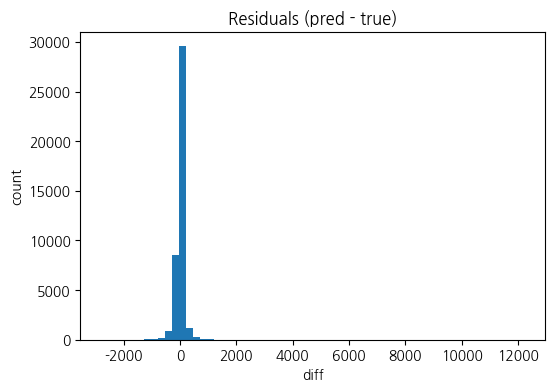

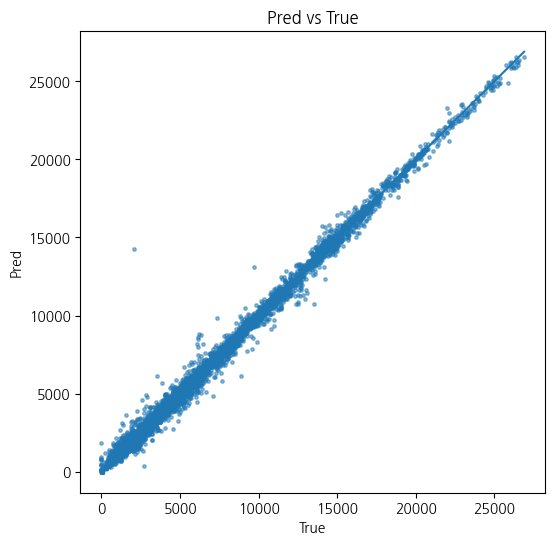

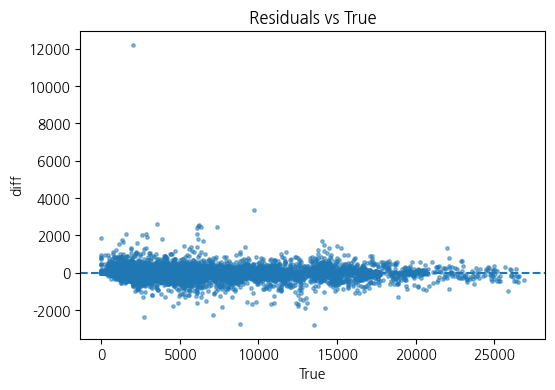

In [8]:
# ======================
# OOF 기반: 예측 vs 실제 차이 진단 스니펫
# ======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 0) 준비: OOF 합치기 ----
assert len(val_oofs_2) > 0, "val_oofs_2가 비어있습니다. 위 학습 루프가 먼저 실행되어야 합니다."
oof = pd.concat(val_oofs_2, ignore_index=True)

# KEYS에 시간/ID 컬럼이 어떤 게 들어있는지 환경마다 다를 수 있어서 안전하게 존재 컬럼만 선택
possible_key_cols = ["num_date_time", "일시", "건물번호", "cluster_id", GROUP_COL] if 'GROUP_COL' in globals() else ["num_date_time", "일시", "건물번호", "cluster_id"]
key_cols = [c for c in possible_key_cols if c in oof.columns]

# ---- 1) 차이/오차 컬럼 추가 ----
eps = 1e-8
oof["diff"] = oof["pred_2"] - oof["y_true"]
oof["abs_diff"] = oof["diff"].abs()
oof["ape"] = oof["abs_diff"] / (oof["y_true"].abs() + eps)                      # MAPE용 (참고지표)
oof["smape_row"] = 2 * oof["abs_diff"] / (oof["y_true"].abs() + oof["pred_2"].abs() + eps)  # 행단위 SMAPE

# ---- 2) 전체 지표 요약 ----
mae = oof["abs_diff"].mean()
rmse = np.sqrt((oof["diff"]**2).mean())
mape = oof["ape"].mean() * 100
smape = oof["smape_row"].mean() * 100

print("=== 전체 검증 지표 ===")
print(f"MAE   : {mae:,.4f}")
print(f"RMSE  : {rmse:,.4f}")
print(f"MAPE% : {mape:,.4f}")     # 분모에 0/극소값 있으면 왜곡 주의
print(f"SMAPE%: {smape:,.4f}")

# ---- 3) 그룹/클러스터/건물별 요약 (있을 때만) ----
def _agg(df):
    return pd.Series({
        "n": len(df),
        "MAE": df["abs_diff"].mean(),
        "RMSE": np.sqrt((df["diff"]**2).mean()),
        "MAPE%": (df["ape"].mean() * 100),
        "SMAPE%": (df["smape_row"].mean() * 100),
        "MedAbsDiff": df["abs_diff"].median()
    })

by_cols_to_try = []
if 'GROUP_COL' in globals() and GROUP_COL in oof.columns:
    by_cols_to_try.append([GROUP_COL])
if "cluster_id" in oof.columns:
    by_cols_to_try.append(["cluster_id"])
if "건물번호" in oof.columns:
    by_cols_to_try.append(["건물번호"])
if set(["cluster_id","건물번호"]).issubset(oof.columns):
    by_cols_to_try.append(["cluster_id","건물번호"])

for cols in by_cols_to_try:
    print("\n=== 그룹 요약:", cols, "===")
    display(oof.groupby(cols).apply(_agg).sort_values("SMAPE%", ascending=False).head(10))   # 최악 10개
    print("\n--- 해당 그룹(상위 10개는 SMAPE 기준) ---")

# ---- 4) 최악/최선 사례 샘플 보기 ----
print("\n=== 샘플: SMAPE 최악 20건 ===")
bad_cases = oof.sort_values("smape_row", ascending=False).head(20)
display(bad_cases[key_cols + ["y_true","pred_2","diff","abs_diff","smape_row"] if key_cols else ["y_true","pred_2","diff","abs_diff","smape_row"]])

print("\n=== 샘플: SMAPE 최선 20건 ===")
good_cases = oof.sort_values("smape_row", ascending=True).head(20)
display(good_cases[key_cols + ["y_true","pred_2","diff","abs_diff","smape_row"] if key_cols else ["y_true","pred_2","diff","abs_diff","smape_row"]])

# ---- 5) 분포/진단 그래프 ----
plt.figure(figsize=(6,4))
plt.hist(oof["diff"], bins=60)
plt.title("Residuals (pred - true)")
plt.xlabel("diff"); plt.ylabel("count")
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(oof["y_true"], oof["pred_2"], s=6, alpha=0.5)
m = max(oof["y_true"].max(), oof["pred_2"].max())
plt.plot([0,m],[0,m])
plt.title("Pred vs True")
plt.xlabel("True"); plt.ylabel("Pred")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(oof["y_true"], oof["diff"], s=6, alpha=0.5)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs True")
plt.xlabel("True"); plt.ylabel("diff")
plt.show()

# ---- 6) 시간/건물 라인플롯(옵션) ----
def plot_building_series(building_id, time_col=None):
    """
    특정 건물의 시간 순서상 True/Pred를 비교해서 라인 플롯
    time_col이 없다면 num_date_time 또는 일시를 자동 탐색
    """
    cand = [time_col] if time_col else []
    for c in ["일시", "num_date_time"]:
        if c not in cand and c in oof.columns:
            cand.append(c)
    assert "건물번호" in oof.columns, "건물번호 컬럼이 필요합니다."
    for tc in cand:
        sub = oof[oof["건물번호"] == building_id].copy()
        if len(sub) == 0:
            print(f"[경고] 건물번호 {building_id} 데이터가 없습니다.")
            return
        # 시간 정렬


In [ ]:
# 최악 SMAPE 건물은 submit0820_추가파생변수반영_3.66로 대체 할까?

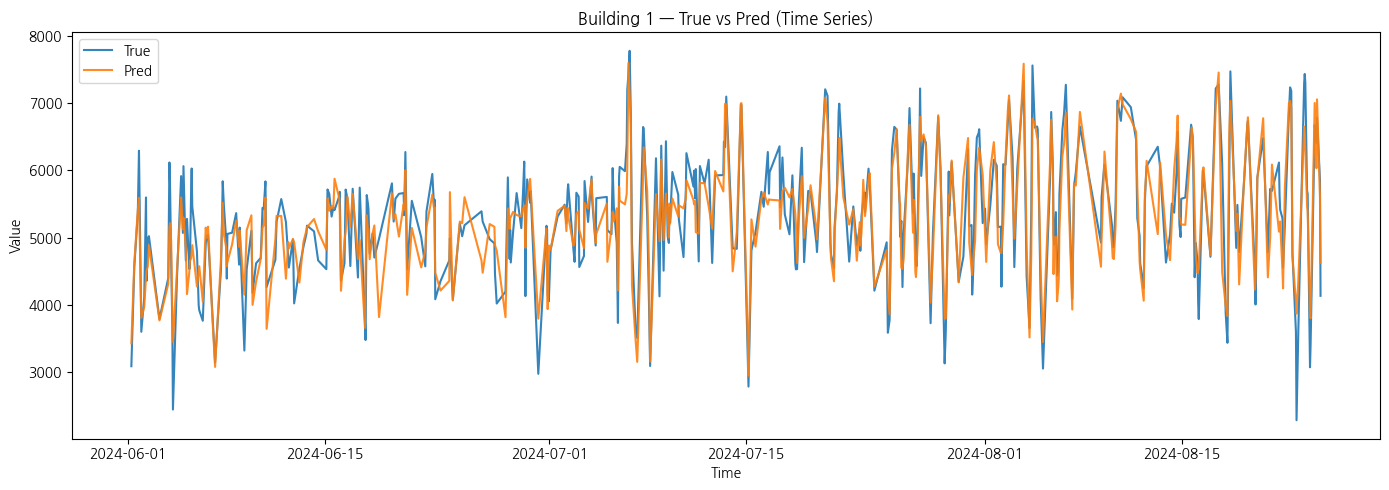

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# ---- 건물 번호 지정 ----
BUILDING_ID = 1   # 원하는 건물번호로 바꿔줘

# 해당 건물 데이터 추출
b = oof[oof["건물번호"] == BUILDING_ID].copy()
assert len(b) > 0, f"건물번호 {BUILDING_ID} 데이터가 없습니다."

# ---- 시간축 만들기 ----
if "일시" in b.columns:
    b["__t"] = pd.to_datetime(b["일시"], errors="coerce")
elif "num_date_time" in b.columns:
    # 예: "1_20200101 00" → 뒤쪽 날짜/시간만 파싱
    b["__t"] = pd.to_datetime(
        b["num_date_time"].astype(str).str.split("_").str[-1],
        errors="coerce",
        format="%Y%m%d %H"
    )
else:
    b["__t"] = b.index  # 시간 정보 없으면 인덱스 사용

b = b.sort_values("__t")

# ---- 라인 플롯 ----
plt.figure(figsize=(14,5))
plt.plot(b["__t"], b["y_true"], label="True", alpha=0.9)
plt.plot(b["__t"], b["pred_2"], label="Pred", alpha=0.9)
plt.title(f"Building {BUILDING_ID} — True vs Pred (Time Series)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()


SMAPE worst building: 33


In [12]:
# ==============================
# 최악 SMAPE 건물: OOF 예측을 sub_alt(answer)로 교체
# sub_alt 컬럼: [num_date_time, answer] 만 있다고 가정
# ==============================
import pandas as pd
import numpy as np

sub_alt = pd.read_csv("Submit/submit0820_추가파생변수반영_3.66.csv", dtype={"num_date_time": str})

# 1) 최악 건물 찾기 (oof에 smape_row, 건물번호가 있다고 가정)
worst_building = oof.groupby("건물번호")["smape_row"].mean().idxmax()
print("SMAPE worst building:", worst_building)

# 2) 교체 대상(OOF) 키 추출: 최악 건물의 num_date_time 목록
mask_worst = (oof["건물번호"] == worst_building)
oof_worst_keys = oof.loc[mask_worst, ["num_date_time", "y_true", "건물번호"]].copy()
oof_worst_keys["num_date_time"] = oof_worst_keys["num_date_time"].astype(str)

# 3) sub_alt에서 해당 num_date_time만 골라오고 열 이름 정리
rep_oof = sub_alt.copy()
rep_oof["num_date_time"] = rep_oof["num_date_time"].astype(str)
rep_oof = rep_oof.merge(
    oof_worst_keys, on="num_date_time", how="inner"
).rename(columns={"answer": "pred_2"})

# 안전: 필요한 컬럼 채워넣기
for col in ["pred_2", "y_true", "건물번호", "num_date_time"]:
    if col not in rep_oof.columns:
        rep_oof[col] = np.nan

# 4) 원본 OOF에서 해당 건물 제거 + 교체분 붙이기
oof_replaced = pd.concat(
    [oof.loc[~mask_worst].copy(), rep_oof[oof.columns.intersection(rep_oof.columns)].copy()],
    ignore_index=True
)

# 5) 교체 후 지표 확인(선택)
eps = 1e-8
oof_replaced["diff"] = oof_replaced["pred_2"] - oof_replaced["y_true"]
oof_replaced["abs_diff"] = oof_replaced["diff"].abs()
oof_replaced["smape_row"] = 2 * oof_replaced["abs_diff"] / (
    oof_replaced["y_true"].abs() + oof_replaced["pred_2"].abs() + eps
)
print(
    "SMAPE%(replaced):",
    100 * oof_replaced["smape_row"].mean()
)

# 6) (옵션) 저장
oof_replaced.to_csv("Submit/oof_replaced_by_worst_building.csv", index=False)
print("[oof_replaced_by_worst_building.csv] 저장 완료")


SMAPE worst building: 33
SMAPE%(replaced): 3.5025750977131906
[oof_replaced_by_worst_building.csv] 저장 완료


In [13]:
oof_replaced

,num_date_time,건물번호,y_true,pred_2,diff,abs_diff,ape,smape_row
0,9_20240702 04,9,1472.02,1393.219238,-78.800762,78.800762,0.053532,0.055005
1,84_20240804 06,84,1351.68,1400.646606,48.966606,48.966606,0.036226,0.035582
2,10_20240701 11,10,5292.91,5442.318848,149.408848,149.408848,0.028228,0.027835
3,10_20240731 07,10,8514.18,7640.946777,-873.233223,873.233223,0.102562,0.108106
4,100_20240606 07,100,1134.24,1110.743652,-23.496348,23.496348,0.020715,0.020932
...,...,...,...,...,...,...,...,...
40369,74_20240818 03,74,781.11,792.424866,11.314866,11.314866,0.014486,0.014381
40370,73_20240730 05,73,559.20,556.029419,-3.170581,3.170581,0.005670,0.005686
40371,54_20240812 23,54,3602.68,3219.167725,-383.512275,383.512275,0.106452,0.112436
40372,74_20240610 15,74,3470.91,3486.097168,15.187168,15.187168,0.004376,0.004366


# 로그루트변환

In [18]:
def smape_fn(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps))


In [24]:
# ---------- 그룹 루프 (로그변환 + 피크 가중치, Optuna 제거) ----------
groups = train[GROUP_COL].dropna().unique()

# 가벼운 그리드: 피크 가중치 후보 (필요하면 조정)
WEIGHT_POW_CANDIDATES = [0.0, 0.5, 0.8, 1.0, 1.2, 1.5]

def smape_fn(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps))

for gkey in groups:
    tr_sub = train[train[GROUP_COL] == gkey].copy()
    te_sub = test[test[GROUP_COL] == gkey].copy()
    if len(tr_sub) == 0:
        continue

    # 1) Feature/Target
    drop_cols_tr = BASE_DROP_COMMON + ["cluster_id", "건물번호", TARGET] + [GROUP_COL]
    X_all = tr_sub.drop(columns=[c for c in drop_cols_tr if c in tr_sub.columns], errors="ignore")
    y_all = tr_sub[TARGET].astype(float)

    # 숫자화 + 결측
    X_all = to_numeric_df(X_all).fillna(0.0)

    # 2) 고정 분할
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_all, y_all, test_size=VAL_SIZE, random_state=38
    )

    # ---- 타깃 로그 변환 ----
    y_tr_log = np.log1p(y_tr.clip(lower=0))
    y_val_log = np.log1p(y_val.clip(lower=0))

    # ---- 기존 best params 불러오기 ----
    base_params = best_params_by_group[gkey].copy()  # 이미 구해둔 파라미터
    # 안전 세팅(로그 스케일 학습 + 조기종료)
    base_params.update({
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "gpu_hist" if USE_GPU else "hist",
        "random_state": RANDOM_STATE,
        "n_jobs": -1,
    })

    # ---- weight_power만 소규모 탐색 ----
    base_med = max(y_tr.median(), 1.0)
    best_w_pow, best_smape = 0.0, float("inf")

    for w_pow in WEIGHT_POW_CANDIDATES:
        sample_weight_tr = np.clip((y_tr / base_med) ** w_pow, 0.5, 5.0)

        m_try = xgb.XGBRegressor(**base_params)
        m_try.fit(
            X_tr, y_tr_log,
            eval_set=[(X_val, y_val_log)],
            sample_weight=sample_weight_tr,
            verbose=False
        )
        best_iter = getattr(m_try, "best_iteration", None)
        pred_val_log = m_try.predict(
            X_val,
            iteration_range=(0, best_iter + 1) if best_iter is not None else None
        )
        pred_val = np.expm1(pred_val_log).clip(min=0)
        cur_smape = smape_fn(y_val.values, pred_val)

        if cur_smape < best_smape:
            best_smape = cur_smape
            best_w_pow = w_pow

    # ---- 최종 모델 학습(선택된 w_pow 사용) ----
    sample_weight_tr = np.clip((y_tr / base_med) ** best_w_pow, 0.5, 5.0)
    m2 = xgb.XGBRegressor(**base_params)
    m2.fit(
        X_tr, y_tr_log,
        eval_set=[(X_val, y_val_log)],
        sample_weight=sample_weight_tr,
        verbose=False
    )
    best_iter = getattr(m2, "best_iteration", None)

    # ---- 검증 예측(원스케일) + 점수 저장 ----
    val_pred_log = m2.predict(
        X_val, iteration_range=(0, best_iter + 1) if best_iter is not None else None
    )
    val_pred = np.expm1(val_pred_log).clip(min=0)
    score = smape_fn(y_val.values, val_pred)
    val_scores_2[gkey] = float(score)
    print(f"[{gkey}] SMAPE={score:.4f} | best_iter={best_iter} | weight_power={best_w_pow}")

    # ---- OOF 저장 (원스케일) ----
    val_keys = tr_sub.loc[X_val.index, KEYS].reset_index(drop=True)
    oof_df = val_keys.copy()
    oof_df["y_true"] = y_val.reset_index(drop=True).values
    oof_df["pred_2"] = val_pred
    val_oofs_2.append(oof_df)

    # ---- TEST 예측(원스케일) ----
    X_test = te_sub.drop(columns=[c for c in BASE_DROP_COMMON + ["cluster_id", GROUP_COL] if c in te_sub.columns], errors="ignore")
    X_test = to_numeric_df(X_test).fillna(0.0)
    X_test = X_test.reindex(columns=X_tr.columns, fill_value=0.0)

    te_pred_log = m2.predict(
        X_test, iteration_range=(0, best_iter + 1) if best_iter is not None else None
    )
    te_pred = np.expm1(te_pred_log).clip(min=0)
    test_preds_2.append(te_sub[KEYS].assign(pred_2=te_pred))


[호텔] SMAPE=10.1696 | best_iter=None | weight_power=0.8
[상용] SMAPE=4.4298 | best_iter=None | weight_power=0.0
[병원] SMAPE=5.4840 | best_iter=None | weight_power=0.5
[학교] SMAPE=5.9508 | best_iter=None | weight_power=0.0
[건물기타] SMAPE=7.2222 | best_iter=None | weight_power=1.0
[아파트] SMAPE=8.9920 | best_iter=None | weight_power=0.0
[연구소] SMAPE=5.8748 | best_iter=None | weight_power=0.0
[백화점10] SMAPE=6.7892 | best_iter=None | weight_power=0.0
[백화점] SMAPE=10.7582 | best_iter=None | weight_power=0.0
[IDC(전화국)] SMAPE=3.0390 | best_iter=None | weight_power=0.0
[공공] SMAPE=9.7348 | best_iter=None | weight_power=0.0
[백화점11] SMAPE=11.9954 | best_iter=None | weight_power=0.0


=== 최종 검증 지표 ===
MAE   : 131.6952
RMSE  : 274.9734
SMAPE%: 5.3804

=== SMAPE 좋은 건물 TOP 5 ===
건물번호
30    0.722
56    0.901
35    0.934
36    1.135
51    1.301
Name: smape_row, dtype: float64

=== SMAPE 나쁜 건물 TOP 5 ===
건물번호
95     10.464
77     10.684
54     11.335
100    12.396
33     12.790
Name: smape_row, dtype: float64


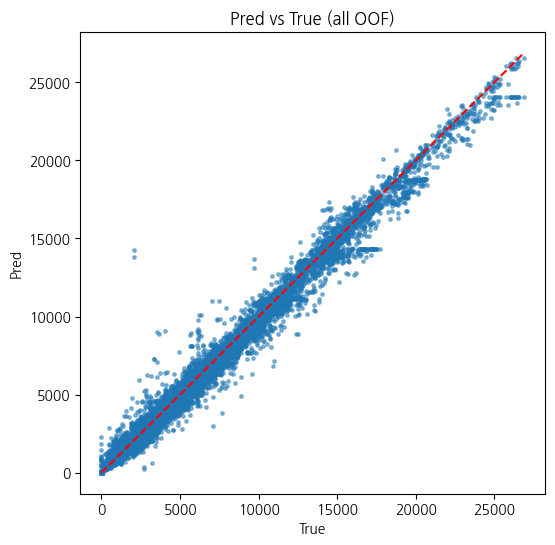

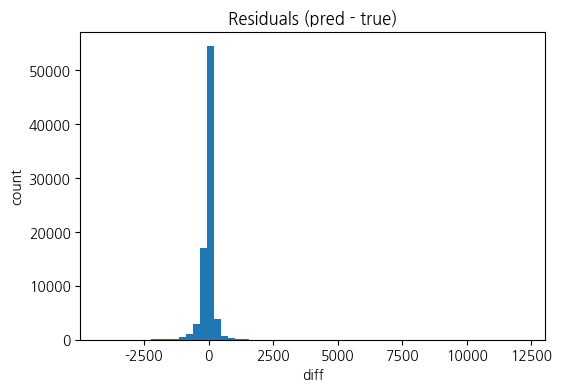

In [25]:
# ======================
# 로그변환 + 가중치 적용 모델의 최종 결과 확인
# ======================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- OOF 합치기 ---
oof_new = pd.concat(val_oofs_2, ignore_index=True)

# --- 기본 오차 계산 ---
eps = 1e-8
oof_new["diff"] = oof_new["pred_2"] - oof_new["y_true"]
oof_new["abs_diff"] = oof_new["diff"].abs()
oof_new["smape_row"] = 2 * oof_new["abs_diff"] / (
    oof_new["y_true"].abs() + oof_new["pred_2"].abs() + eps
)

# --- 전체 지표 ---
MAE   = oof_new["abs_diff"].mean()
RMSE  = np.sqrt((oof_new["diff"]**2).mean())
SMAPE = oof_new["smape_row"].mean() * 100

print("=== 최종 검증 지표 ===")
print(f"MAE   : {MAE:,.4f}")
print(f"RMSE  : {RMSE:,.4f}")
print(f"SMAPE%: {SMAPE:,.4f}")

# --- 건물별 SMAPE 상위/하위 ---
if "건물번호" in oof_new.columns:
    by_building = oof_new.groupby("건물번호")["smape_row"].mean().sort_values()
    print("\n=== SMAPE 좋은 건물 TOP 5 ===")
    print((by_building.head(5) * 100).round(3))
    print("\n=== SMAPE 나쁜 건물 TOP 5 ===")
    print((by_building.tail(5) * 100).round(3))

# --- 예측 vs 실제 산점도 ---
plt.figure(figsize=(6,6))
plt.scatter(oof_new["y_true"], oof_new["pred_2"], s=6, alpha=0.5)
m = max(oof_new["y_true"].max(), oof_new["pred_2"].max())
plt.plot([0,m],[0,m],"--",color="red")
plt.title("Pred vs True (all OOF)")
plt.xlabel("True"); plt.ylabel("Pred")
plt.show()

# --- Residual 히스토그램 ---
plt.figure(figsize=(6,4))
plt.hist(oof_new["diff"], bins=60)
plt.title("Residuals (pred - true)")
plt.xlabel("diff"); plt.ylabel("count")
plt.show()


In [29]:
import pandas as pd
import numpy as np
from pathlib import Path

# =========================
# 0) 경로/이름 세팅
# =========================
SUBMIT_DIR = Path("Submit")
SUBMIT_DIR.mkdir(parents=True, exist_ok=True)
ALT_PATH = SUBMIT_DIR / "submit0820_추가파생변수반영_3.66.csv"   # 기존 대체용 제출 파일
SAMPLE_PATH = SUBMIT_DIR / "sample_submission.csv"              # 샘플 제출(있으면 정렬/키 정합에 사용)
OUT_PATH = SUBMIT_DIR / "submission_xgb_logw_final.csv"         # 최종 제출 파일 이름

# =========================
# 1) 검증 OOF 합치고 최악 건물 재확인(선택)
# =========================
oof_new = pd.concat(val_oofs_2, ignore_index=True)
eps = 1e-8
oof_new["diff"] = oof_new["pred_2"] - oof_new["y_true"]
oof_new["abs_diff"] = oof_new["diff"].abs()
oof_new["smape_row"] = 2 * oof_new["abs_diff"] / (oof_new["y_true"].abs() + oof_new["pred_2"].abs() + eps)

if "건물번호" in oof_new.columns:
    worst_building = oof_new.groupby("건물번호")["smape_row"].mean().idxmax()
    print("SMAPE worst building (OOF):", worst_building)
else:
    worst_building = None
    print("경고: OOF에 '건물번호'가 없어 최악 건물 교체는 생략합니다.")

# =========================
# 2) 테스트 예측 합치기
# =========================
test_all = pd.concat(test_preds_2, ignore_index=True)

# 안전: 타입/결측 처리
test_all["num_date_time"] = test_all["num_date_time"].astype(str)
test_all["pred_2"] = pd.to_numeric(test_all["pred_2"], errors="coerce").fillna(0.0)
test_all["pred_2"] = test_all["pred_2"].clip(lower=0)   # 음수 예측 방지

# =========================
# 3) (옵션) 최악 건물만 다른 제출값으로 교체
#     - sub_alt: [num_date_time, answer] 만 있다고 가정
# =========================
if worst_building is not None and ALT_PATH.exists():
    sub_alt = pd.read_csv(ALT_PATH, dtype={"num_date_time": str})
    sub_alt["answer"] = pd.to_numeric(sub_alt["answer"], errors="coerce")
    sub_alt = sub_alt.dropna(subset=["num_date_time", "answer"])

    if "건물번호" in test_all.columns:
        mask_worst = (test_all["건물번호"] == worst_building)
        # 교체 대상 키 추출
        test_worst_keys = test_all.loc[mask_worst, ["num_date_time"]].drop_duplicates()
        # 매칭(해당 시점만)
        rep = test_worst_keys.merge(sub_alt, on="num_date_time", how="left")
        # 실제 교체값이 있는 시점만 업데이트
        has_rep = rep["answer"].notna()
        if has_rep.any():
            rep_map = rep.loc[has_rep, ["num_date_time", "answer"]].set_index("num_date_time")["answer"]
            idx = test_all.index[mask_worst & test_all["num_date_time"].isin(rep_map.index)]
            test_all.loc[idx, "pred_2"] = test_all.loc[idx, "num_date_time"].map(rep_map).values
            print(f"최악 건물({worst_building}) 교체 반영: {has_rep.sum()}개 시점")
        else:
            print("교체할 시점에 sub_alt 값이 없어 교체 생략")
    else:
        print("경고: test_all에 '건물번호'가 없어 교체 불가 → 생략")
else:
    print("최악 건물 교체 단계 생략(이유: worst_building 없음 또는 ALT 파일 없음)")

# =========================
# 4) 제출 포맷 만들기
#     - 기본 포맷: [num_date_time, answer]
#     - sample_submission.csv가 있으면 그 순서/키에 맞춰 merge
# =========================
if SAMPLE_PATH.exists():
    sample = pd.read_csv(SAMPLE_PATH, dtype={"num_date_time": str})
    # sample 키 기준으로 정렬/정합
    submit = sample[["num_date_time"]].merge(
        test_all[["num_date_time", "pred_2"]],
        on="num_date_time", how="left"
    )
    # 누락값은 0으로
    submit["answer"] = submit["pred_2"].fillna(0.0).clip(lower=0)
    submit = submit[["num_date_time", "answer"]]
else:
    # 샘플이 없으면 num_date_time만으로 유일해야 함
    # 혹시 중복 있으면 평균(또는 마지막)으로 집계
    dup_cnt = test_all["num_date_time"].value_counts().loc[lambda s: s > 1]
    if len(dup_cnt) > 0:
        print("경고: 동일 num_date_time 중복 존재 → 평균으로 집계합니다. 예:", dup_cnt.head(3).to_dict())
        submit = (test_all
                  .groupby("num_date_time", as_index=False)["pred_2"].mean()
                  .rename(columns={"pred_2": "answer"}))
    else:
        submit = test_all.rename(columns={"pred_2": "answer"})[["num_date_time", "answer"]]

    # 시간 정렬(선택)
    # 가능한 포맷: "{building}_{YYYYMMDD HH}" → 뒤쪽 날짜로 정렬 시도
    try:
        _t = pd.to_datetime(submit["num_date_time"].astype(str).str.split("_").str[-1],
                            format="%Y%m%d %H", errors="coerce")
        submit = submit.assign(__t=_t).sort_values("__t").drop(columns="__t")
    except Exception:
        pass

# 안전: 숫자화/클리핑
submit["answer"] = pd.to_numeric(submit["answer"], errors="coerce").fillna(0.0).clip(lower=0)

# (필요 시) 반올림 규칙이 있으면 적용
# 예: 소수점 6자리
submit["answer"] = submit["answer"].round(6)

# =========================
# 5) 저장
# =========================
# SAMPLE_PATH를 이미 위에서 썼으므로 그대로 사용
if SAMPLE_PATH.exists():
    sample_order = pd.read_csv(SAMPLE_PATH, dtype={"num_date_time": str})[["num_date_time"]]
    submit_final = sample_order.merge(submit, on="num_date_time", how="left")
    submit_final["answer"] = pd.to_numeric(submit_final["answer"], errors="coerce").fillna(0.0).clip(lower=0).round(6)
    submit_final.to_csv(OUT_PATH, index=False)
    print(f"[OK] 최종 제출 저장(샘플 순서 적용): {OUT_PATH}  | shape={submit_final.shape}")
else:
    submit.to_csv(OUT_PATH, index=False)
    print(f"[OK] 최종 제출 저장: {OUT_PATH}  | shape={submit.shape}")


SMAPE worst building (OOF): 33
최악 건물(33) 교체 반영: 168개 시점
경고: 동일 num_date_time 중복 존재 → 평균으로 집계합니다. 예: {'1_20240825 00': 2, '94_20240829 05': 2, '94_20240829 07': 2}
[OK] 최종 제출 저장: Submit/submission_xgb_logw_final.csv  | shape=(16800, 2)


In [32]:
# 샘플 불러오기
sample = pd.read_csv('Data/sample_submission.csv', dtype={"num_date_time": str})[["num_date_time"]]

# 샘플 키 기준으로 정렬 & 누락 보완
submit_final = sample.merge(submit, on="num_date_time", how="left")

# answer 컬럼 정리
submit_final["answer"] = (
    pd.to_numeric(submit_final["answer"], errors="coerce")
      .fillna(0.0)
      .clip(lower=0)
      .round(6)
)

# 저장
submit_final.to_csv(OUT_PATH, index=False)
print(f"[OK] 최종 제출 저장 (샘플 순서 적용): {OUT_PATH}, shape={submit_final.shape}")

[OK] 최종 제출 저장 (샘플 순서 적용): Submit/submission_xgb_logw_final.csv, shape=(16800, 2)


In [33]:
submit_final

,num_date_time,answer
0,1_20240825 00,4916.669678
1,1_20240825 01,4728.371338
2,1_20240825 02,4610.544189
3,1_20240825 03,4328.175293
4,1_20240825 04,4166.913086
...,...,...
16795,100_20240831 19,2434.155029
16796,100_20240831 20,2390.947632
16797,100_20240831 21,2304.974365
16798,100_20240831 22,2487.614746
